# Objective:
* **To get a overview of settlements change around the geographical region of Pune,India using Human Settlements Layer Dataset hosted on Google Earth Engine.**

# Methodlogy (Rough) 

1) Using Preprocessed LANDSAT 7 satellite images available on google earth engine for visualization of some Indices.

**Some Useful Formulas**
 * Normallized Difference Vegetative Index :  NDVI = NIR - RED / (NIR + RED) 
 * Normallized Difference Built Up Index   :  NDBI = SWIR- NIR / (SWIR + NIR) 
 * Built Up                                :  BU   = Max(0,NDBI)*255 - Max(0,NDVI)*255, BU = BU>107
 * Normalized Difference Water Index       :  NDWI =  NIR - SWIR/(NIR + SWIR)
 * Modified NDWI :                            MNDWI = Green - SWIR/ (SWIR + Green)


2) Using Human settlements layer for Analysis of settlement area change over the region of Pune,India.
 

# References and Resources:
* Paper: Normalized Buildup Urban Area. [ https://is.muni.cz/el/1431/podzim2012/Z8114/um/35399132/35460312/ndbi.pdf ]
* Paper : Buildup Area and Vegetation Area Extraction [ http://article.sapub.org/10.5923.j.ijaf.20130307.04.html ]
* Paper : Estimating Urban Greeness . [ https://www.sciencedirect.com/science/article/pii/S1110982319304211 ]
* Paper : Improving NDBI .[ https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681 ]
* Paper : Urban Sprawl: Lucknow City [ http://www.ijhssi.org/papers/v4(5)/Version-2/B0452011020.pdf ]
* Paper : [ https://www.researchgate.net/publication/355979192_Assessment_of_Change_in_Urban_Green_Spaces_Using_Sentinel_2_MSI_Data_and_GIS_Techniques_A_Case_Study_in_Thanh_Hoa_City_Vietnam ]
* Paper : Enhanced Built up index [ https://www.researchgate.net/publication/258710455_Enhanced_Built-Up_and_Bareness_Index_EBBI_for_Mapping_Built-Up_and_Bare_Land_in_an_Urban_Area ]
* Tutorial GEE: Calculating image statistics [ https://developers.google.com/earth-engine/guides/reducers_reduce_region ]
* Blog  : Landcover detection [ https://spatialthoughts.com/2020/06/19/calculating-area-gee/ ]
* Blog  : Image Analysis and mapping using NDVI [ https://www.analyticsvidhya.com/blog/2021/05/image-analysis-and-mapping-in-earth-engine-using-ndvi/ ]
* Tutorial GEE: Quantifying Forest change [ https://developers.google.com/earth-engine/tutorials/tutorial_forest_03 ]
* Tutorial Landuse Clustering: [ https://examples.pyviz.org/landsat_clustering/landuse_clustering.html ]
* Tutorial Earth DS   : [ https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/ ]
* Conv ee tiles to np arrays: https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn
* folium cloropleth map: https://rsandstroem.github.io/GeoMapsFoliumDemo.html
* GEEMAP : https://pythonawesome.com/a-python-package-for-interactive-mapping-with-google-earth-engine/

# 

# Imports

In [64]:
import ee 
import numpy as np 
import webbrowser
import os 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import folium
import pickle
import pandas as pd
from PIL import Image
import IPython.display as disp
%matplotlib inline


# Google earth Engine Helper functions

In [15]:
# setup to add ee layer to folium

def add_ee_layer(self, ee_image_object, vis_params, name,opacity=0.75):
    '''function to add GEE layer to folium,
    Source : GEE'''
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
          tiles=map_id_dict['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          name=name,
          opacity=opacity,
          overlay=True,
          control=True
      ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer


def get_best_image(image_collection,
                   year,
                   area_of_interest,
                   month=10):
    '''filter the best image( with the least cloud cover value) for the given year and given month'''

    start_date = ee.Date.fromYMD(**{
        'day':1 ,
        'month': month,
        'year' : year})
    end_date = ee.Date.fromYMD(**{
        'day':30 ,
        'month': month,
        'year' : year})
    
    print(image_collection.filterDate(start_date,end_date).size().getInfo())
    
    if not area_of_interest:
        # sort image by asc order of cloud pixel values
        img = image_collection.filterDate(start_date,end_date).sort('CLOUD_COVER').first()
    else:
        img = image_collection.filterDate(start_date,end_date).sort('CLOUD_COVER').first().clip(area_of_interest)
        
    
    return img 


#from https://climada-python.readthedocs.io/en/stable/tutorial/climada_util_earth_engine.html
def get_url(name, image, scale, region):
    """It will open and download automatically a zip folder containing Geotiff data of 'image'.
    If additional parameters are needed, see also:
    https://github.com/google/earthengine-api/blob/master/python/ee/image.py

    Parameters:
        name (str): name of the created folder
        image (ee.image.Image): image to export
        scale (int): resolution of export in meters (e.g: 30 for Landsat)
        region (list): region of interest

    Returns:
        path (str)
     """
    path = image.getDownloadURL({
        'name':(name),
        'scale': scale,
        'region':(region)
        })

    webbrowser.open_new_tab(path)
    return path

# Authenticating and Initializing earth engine

In [52]:
# Authenticate (generate a authentication token and authenticate)
ee.Authenticate()

In [4]:
#Initialize
ee.Initialize()

# Area of Interest

**The following geometry is used for only Visualization Landsat Images. It is not the district boundry geometry**

In [ ]:
# Area of Interest 

with open('../input/pune-coordinates/bounding_polygons.pkl','rb') as f:
    pune_cr = pickle.load(f)

    
#converting into polygon object with a buffer of 30 kms around it 
aoi = ee.geometry.Geometry.Polygon(list(pune_cr['pune_urban'].values())).buffer(30000)

# mean latitude and longitude
mean_cr=list(pd.DataFrame(pune_cr['pune_urban'].values()).mean())

**Getting the district boundaries(will be used for analysis)**

In [56]:
#the dataset with boundaries info
bounds= ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

#get geometry for Pune
pune_dist = bounds.filter(ee.Filter.eq('ADM2_NAME', 'Pune')).geometry()

pune_dist_area=ee.Number(pune_dist.area()).divide(1e+6).round().getInfo() 

print(f'Total Administrative boundary area of Pune is {pune_dist_area} Sq-Km')

Total Administrative boundary area of Pune is 15650 Sq-Km


# Getting the Image collection for visualization

In [11]:
# Landsat 7 image collection surface reflectance  (1999- 2021) Level -2 - tier 1
L7=ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterBounds(aoi)

# first image of the collection 
image = L7.filter(ee.Filter.calendarRange(1999,2003,'year')).sort('CLOUDY_PIXEL_PERCENTAGE').first().clip(aoi)



print('Number of Images in the collection is ',L7.size().getInfo())
# checking the date when image was ingested 
print('Date of Ingestion for sample Image :'  ,ee.Date(image.get('system:time_start')).format().getInfo())

Number of Images in the collection is  279
Date of Ingestion for sample Image : 1999-10-29T05:20:42


# Visualizing First Image of the collection in RGB

# **Note:**
* The Google Earth Engine Tiles on top of Folium Maps dissapear after a couple of days, please rerun the notebook if you wish to see them on folium maps.

In [12]:
# Define the visualization parameters.
# B1 is Blue,B2 is Green ,B3 is Red

image_viz_params = {
    'bands': ['B3', 'B2', 'B1'],
    'min': 0,
    'max': 2000,
    'gamma': [0.95, 1.1, 1]
}


# Define a map centered on AOI.
map_l8 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)


# Add the image layer to the map and display it.
map_l8.add_ee_layer(image, image_viz_params, 'color composite')
map_l8.add_child(folium.LayerControl())
display(map_l8)

In [28]:
#check the image 

print('Color Composite Raster')
url_im = image.select(['B3', 'B2', 'B1']).getThumbUrl(image_viz_params,)
disp.Image(url=url_im,width=800)


Color Composite Raster


# Checking various Indices

# Normalized Difference Vegetative Index

**HTML color generator : [  https://www.computerhope.com/tips/tip143.htm ]**

In [20]:

# calculating normalized diffrence
ndvi = image.normalizedDifference(['B4','B3'])


#mask regions with NDVI <0.25
mask_ndvi = ndvi.gte(0.25)
ndvi1 = ndvi.updateMask(mask_ndvi)

# map
map_3 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
# palette = ListedColormap(["white", "tan", "springgreen", "darkgreen"])
ndvi_viz = {'min': 0.17, 'max': 1, 'palette': ['#8c564b','#D6A896','#A2C177','#75A82C','5F9A0B']}

# Add the image layer to the map and display it.
map_3.add_ee_layer(ndvi1,ndvi_viz,'NDVI')
map_3.add_child(folium.LayerControl())
print('Normalized Difference Vegetative Index')
display(map_3)

Normalized Difference Vegetative Index


In [124]:
#check the image 
print('Vegetation Index Raster')
url_im = ndvi1.getThumbUrl(ndvi_viz)
disp.Image(url=url_im,width=800)

Vegetation Index Raster


# Modified Normalized Water Index

In [22]:

# calculating normalized diffrence
mndwi = image.normalizedDifference(['B3','B5'])


#mask 
mask = mndwi.gte(-0.01)
mndwi = mndwi.updateMask(mask)

# map
map_2 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
mndwi_viz = {'min': -0.2, 'max': 0.5, 'palette': ['lightblue','blue']}

print('Normalized Difference Water Index')
# Add the image layer to the map and display it.
map_2.add_ee_layer(mndwi,mndwi_viz,'NWDI')
map_2.add_child(folium.LayerControl())
display(map_2)

Normalized Difference Water Index


In [27]:
print('Water Index Raster')
url_im = mndwi.getThumbUrl(mndwi_viz)
disp.Image(url=url_im,width=800)

Water Index Raster


**Calculating NDBI**

In [24]:

# calculating normalized diffrence
ndbi = image.normalizedDifference(['B6','B4'])


#taking values greater than 0.2 and less than 0.5
ndbi_mask = ndbi.gte(0.25).And(ndbi.lte(0.45))

ndbi=ndbi.updateMask(ndbi_mask)
# map
map_3 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
colormap = ['yellow','orange','brown']
ndbi_viz = {'min': 0.2, 'max': 0.5, 'palette': colormap}


print('Normalized Difference BuiltUp Index')
# Add the image layer to the map and display it.
map_3.add_ee_layer(ndbi,ndbi_viz,'NDBI')
map_3.add_child(folium.LayerControl())
display(map_3)

Normalized Difference BuiltUp Index


In [26]:
print('Built Up Raster')
url_im = ndbi.getThumbUrl(ndbi_viz)
disp.Image(url=url_im,width=800)

Built Up Raster


# Global Human Settlements Layer
* **ABOUT:** 

The GHSL relies on the design and implementation of new spatial data mining technologies allowing to automatically process and extract analytics and knowledge from large amount of heterogeneous data including: global, fine-scale satellite image data streams, census data, and crowd sources or volunteered geographic information sources.

The GHS-SMOD is the rural-urban Settlement classification MODel adopted by the GHSL. It is the representation of the degree of urbanization (DEGURBA) concept into the GHSL data scenario. Each grid in the GHS-SMOD has been generated by integrating the GHSL built-up areas and GHSL population grids data for reference epochs: 1975, 1990, 2000, 2015.

The DEGURBA classification schema is a people-based definition of cities and settlements: it operates using as main input a 1 km² grid cell accounting for population at a given point in time. The DEGURBA discriminates the population grid cells in three main classes: 'urban centers' (cities), 'urban clusters' (towns and suburbs), and 'rural grid cells'. (base). These class abstractions translate to 'high density clusters (HDC)', 'low density clusters (LDC)', and 'rural grid cells (RUR)', respectively, in the GHS-SMOD implementation.

The 'HDC' differ from the DEGURBA 'urban centers' in that they account for the over-fragmentation of cities in regions with large low-density residential development by integrating the built-up layer. In the GHS-SMOD representation, the 'HDC' are the spatial generalization of contiguous population grid cells (4-connectivity, gap-filling) with a density of at least 1500 inhabitants per km² or a density of built-up surface > 50%, and a minimum total resident population of 50000. The 'LDC' are continuous grid cells with a density of at least 300 inhabitants per km² and a minimum total population of 5000. The 'RUR' are grid cells outside 'HDC' and 'LDC' with population > 0 and < 300. Everything else is classified as inhabited areas where population = 0.

This dataset was produced in the World Mollweide projection (EPSG:54009).
* source: https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_SMOD_POP_GLOBE_V1?hl=en

**Helper Functions**

In [110]:

def get_df(img_collection_info,
           bands):
    '''get a dataframe of values for the given Bands'''
    
    
    df = pd.DataFrame(img_collection_info)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *bands]].dropna()

    # Convert the data to numeric values.
    for band in bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    #lat-long of point as location
    df['location']=df.apply(lambda x : (x['latitude'],x['longitude']),axis=1)
    
    
    # Keep the columns of interest.
    df = df[['time','datetime','location',  *bands]]

    return df


def get_setl_stats(img,
                   total_area=pune_dist_area):
    
    '''get settlement type stats for an Global HUman Settlements layer'''
    
    area = ee.Image.pixelArea()
    #to calculate sum of Area
    reducer_dict = {
                  'reducer': ee.Reducer.sum(),
                  'geometry': img.geometry(),
                  'scale': 1000,#scale in meters
                  'maxPixels': 1e9
                }
    
    
    #high density
    high = round(img.updateMask(img.eq(3)).multiply(area).reduceRegion(**reducer_dict).get('smod_code').getInfo() / 1e+6,
                 3)
    #medium density
    medium = round(img.updateMask(img.eq(2)).multiply(area).reduceRegion(**reducer_dict).get('smod_code').getInfo() / 1e+6,
                   3)

    #low denisty
    low = round(img.updateMask(img.eq(1)).multiply(area).reduceRegion(**reducer_dict).get('smod_code').getInfo() / 1e+6,
                3)
    
     
    for typ in ['high','medium','low']:
        val=eval(typ)
        print(f'Area is Sq-km of {typ} density settlements is {val}, {round(100*(val/total_area),3)} % of total area')
        print('.'*20,'-'*20,'.'*20)
        
    return high,medium,low


def save_image(image,title,path='./'):
    try:
        im = Image.fromarray(image)
        im.save(os.path.join(path,title,'.jpg'))
        print(f'{title}.jpg saved ')
    except Exception as e:
        print('Error saving Image \n',e)
        
        
def show_image(arr,title,save=True):
    
    
#     cmap = ListedColormap(['green','yellow','orange','brown'])
    ax=plt.figure(figsize=(12,12))
    
    plt.imshow(arr)
    plt.axis('off')
    plt.colorbar(orientation='horizontal')
    plt.title(f'{title}')
    plt.show()
    
    if save:
        plt.imsave(arr=arr,fname=f'{title}.png')
        

In [57]:
#get the Human Settlements layer 
human_settlements = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1").filterBounds(pune_dist)
#list of images
hs_list = human_settlements.toList(4)

#get each Image of the Human setttlements layer
hs1 = ee.Image(hs_list.get(0)).clip(pune_dist)   # 1975
hs2 = ee.Image(hs_list.get(1)).clip(pune_dist)   #1990
hs3 = ee.Image(hs_list.get(2)).clip(pune_dist)   #2000
hs4 = ee.Image(hs_list.get(3)).clip(pune_dist)   #2015

In [33]:
# Dataset Human Settlements Layer-band name: smod_codes

#what value of this band means
smod_code_dict = {0:'un-inhabited region',
                  1: 'rural grid cells',
                  2: 'low density clusters',
                  3: 'high density clusters'}

# Visualizing Settlements Layer 

# Year : 1975

In [90]:
year = 1975
print(f'For Year {year}')
sts1=get_setl_stats(hs1)

For Year 1975
Area is Sq-km of high density settlements is 926.736, 5.922 % of total area
.................... -------------------- ....................
Area is Sq-km of medium density settlements is 471.912, 3.015 % of total area
.................... -------------------- ....................
Area is Sq-km of low density settlements is 1147.41, 7.332 % of total area
.................... -------------------- ....................


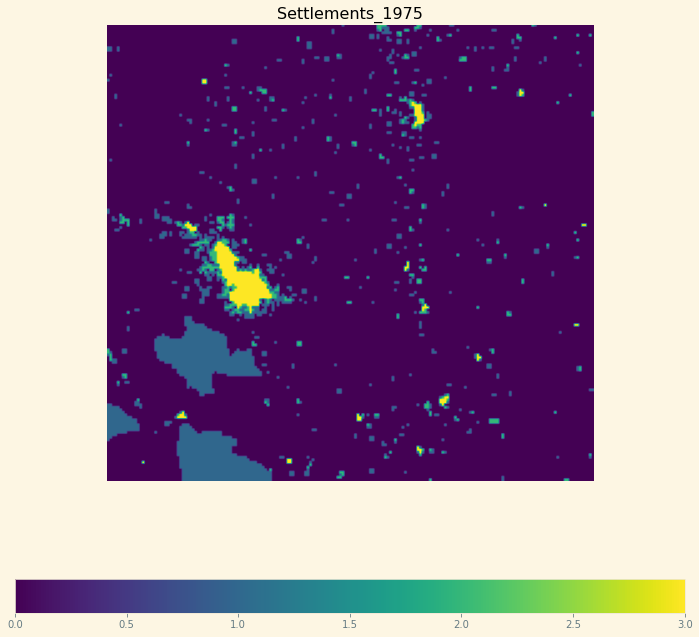

In [111]:
#get the image as an array
arr1 = np.array(ee.Image(hs_list.get(0)).sampleRectangle(region=pune_dist).get('smod_code').getInfo())

#show image and save
show_image(arr1,'Settlements_1975',True)

In [113]:
# map
map_4 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
hs_viz = {'min': 0,
            'max': 3,
            'palette': ['green','yellow','orange','brown']}


print('Settlements in 1975')
# Add the image layer to the map and display it.
map_4.add_ee_layer(hs1,hs_viz,'Builtup Area')
map_4.add_child(folium.LayerControl())
display(map_4)

Settlements in 1975


# Year : 1990

In [91]:
year = 1990
print(f'For Year {year}')
sts2=get_setl_stats(hs2)

For Year 1990
Area is Sq-km of high density settlements is 1466.189, 9.369 % of total area
.................... -------------------- ....................
Area is Sq-km of medium density settlements is 826.45, 5.281 % of total area
.................... -------------------- ....................
Area is Sq-km of low density settlements is 1663.134, 10.627 % of total area
.................... -------------------- ....................


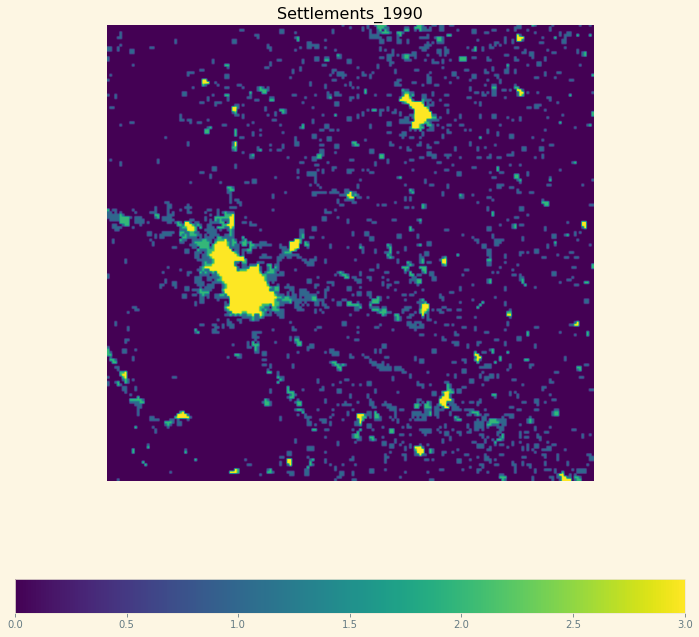

In [114]:
#get the image as an array
arr2 = np.array(ee.Image(hs_list.get(1)).sampleRectangle(region=pune_dist).get('smod_code').getInfo())

#show image and save
show_image(arr2,'Settlements_1990',True)

In [93]:
# map
map_5 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 

print(f'Settlements in {year}')
# Add the image layer to the map and display it.
map_5.add_ee_layer(hs2,hs_viz,'Builtup Area')
map_5.add_child(folium.LayerControl())
display(map_5)

Settlements in 1990


# Year : 2000

In [104]:
year = 2000
print(f'For Year {year}')
sts3=get_setl_stats(hs3)

For Year 2000
Area is Sq-km of high density settlements is 2071.682, 13.238 % of total area
.................... -------------------- ....................
Area is Sq-km of medium density settlements is 1073.863, 6.862 % of total area
.................... -------------------- ....................
Area is Sq-km of low density settlements is 2317.576, 14.809 % of total area
.................... -------------------- ....................


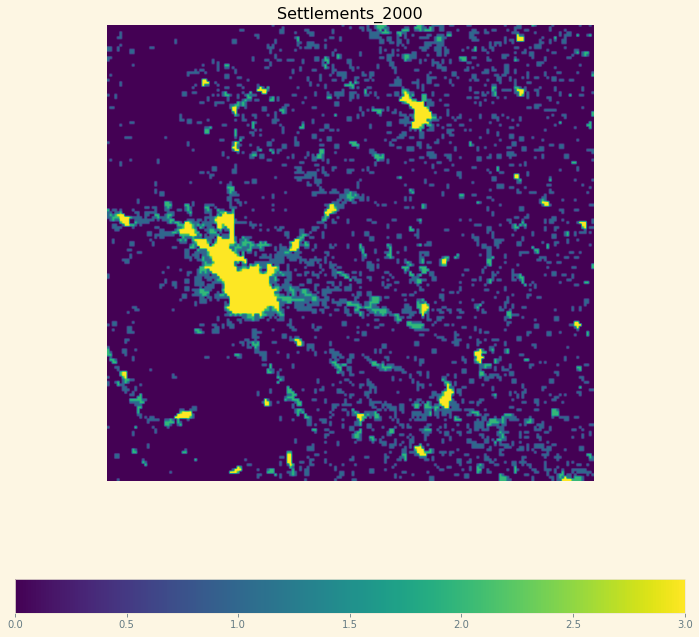

In [115]:
#get the image as an array
arr3 = np.array(ee.Image(hs_list.get(2)).sampleRectangle(region=pune_dist).get('smod_code').getInfo())

#show image and save
show_image(arr3,'Settlements_2000',True)

In [96]:
# map
map_6 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
hs_viz = {'min': 0,
            'max': 3,
            'palette': ['green','yellow','orange','brown']}


print(f'Settlements in {year}')
# Add the image layer to the map and display it.
map_6.add_ee_layer(hs3,hs_viz,'Builtup Area')
map_6.add_child(folium.LayerControl())
display(map_6)

Settlements in 2000


# Year 2015

In [103]:
year = 2015
print(f'For Year {year}')
sts4=get_setl_stats(hs4)

For Year 2015
Area is Sq-km of high density settlements is 2870.033, 18.339 % of total area
.................... -------------------- ....................
Area is Sq-km of medium density settlements is 1720.622, 10.994 % of total area
.................... -------------------- ....................
Area is Sq-km of low density settlements is 3571.448, 22.821 % of total area
.................... -------------------- ....................


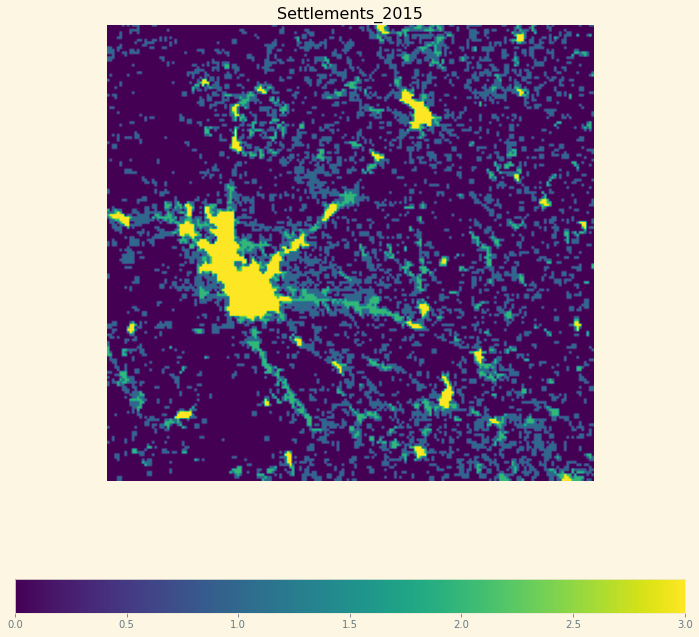

In [116]:
#get the image as an array
arr4 = np.array(ee.Image(hs_list.get(3)).sampleRectangle(region=pune_dist).get('smod_code').getInfo())

#show image and save
show_image(arr4,'Settlements_2015',True)

In [101]:
# map
map_7 = folium.Map(location=[mean_cr[1],mean_cr[0]], zoom_start=10)
 
hs_viz = {'min': 0,
            'max': 3,
            'palette': ['green','yellow','orange','brown']}


print(f'Settlements in {year}')
# Add the image layer to the map and display it.
map_7.add_ee_layer(hs4,hs_viz,'Builtup Area')
map_7.add_child(folium.LayerControl())
display(map_7)

Settlements in 2015


# Charting growth 

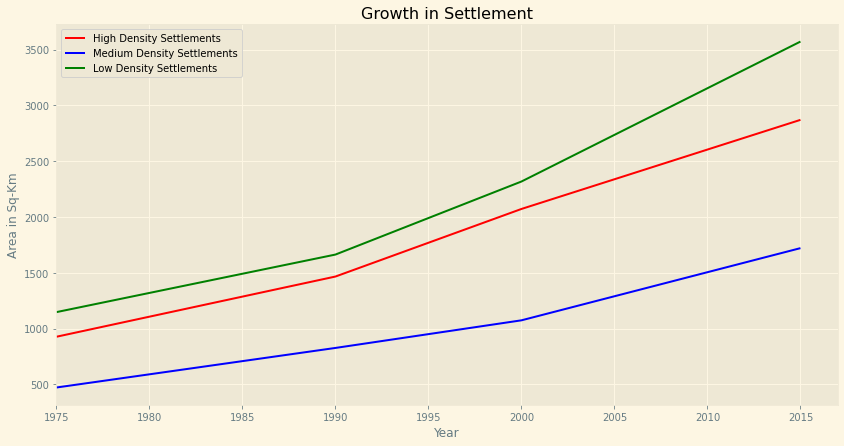

In [109]:
#get data saved Earlier
years = [1975,1990,2000,2015]
stats = [sts1,sts2,sts3,sts4]
high_den= [i[0] for i in stats]
med_den= [i[1] for i in stats]
low_den= [i[2] for i in stats]



#plot

plt.style.use('Solarize_Light2')
ax=plt.figure(figsize=(14,7))

plt.title('Growth in Settlement')
plt.plot(years,high_den,label='High Density Settlements',color='r')
plt.plot(years,med_den,label='Medium Density Settlements',color='b')
plt.plot(years,low_den,label='Low Density Settlements',color='g')
plt.xlim(left=1975)
plt.xlabel('Year')
plt.ylabel('Area in Sq-Km')
plt.legend()

plt.savefig('growth.png')
plt.show()

# Visualizing areas of growth 

# Period : 1975-1990

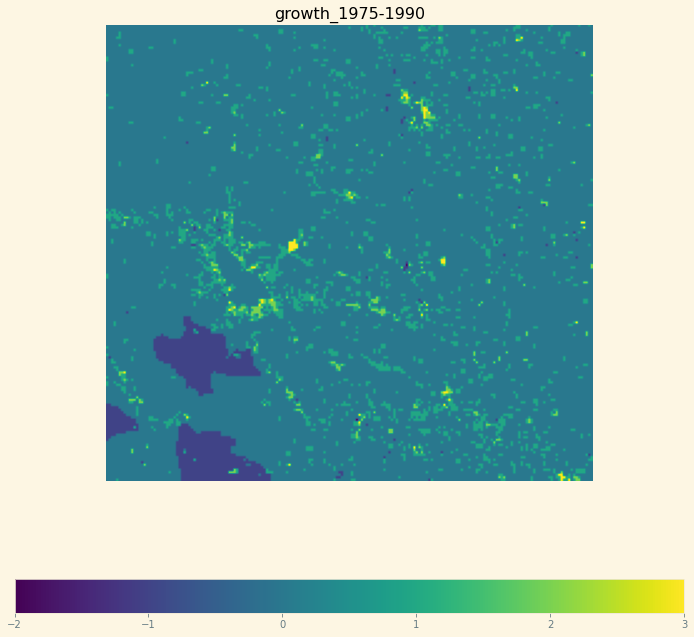

In [122]:

#show image and save
show_image(arr2-arr1,'growth_1975-1990',True)

# 

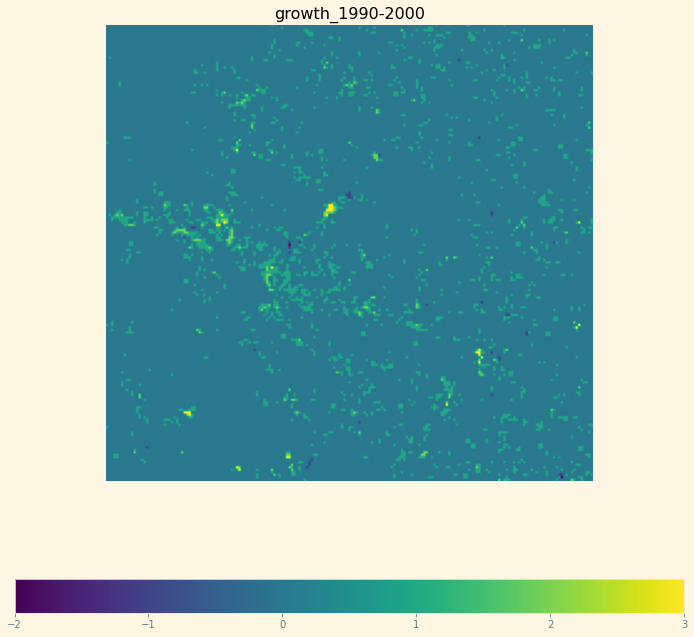

In [123]:

#show image and save
show_image(arr3-arr2,'growth_1990-2000',True)

# Period 2000:2015

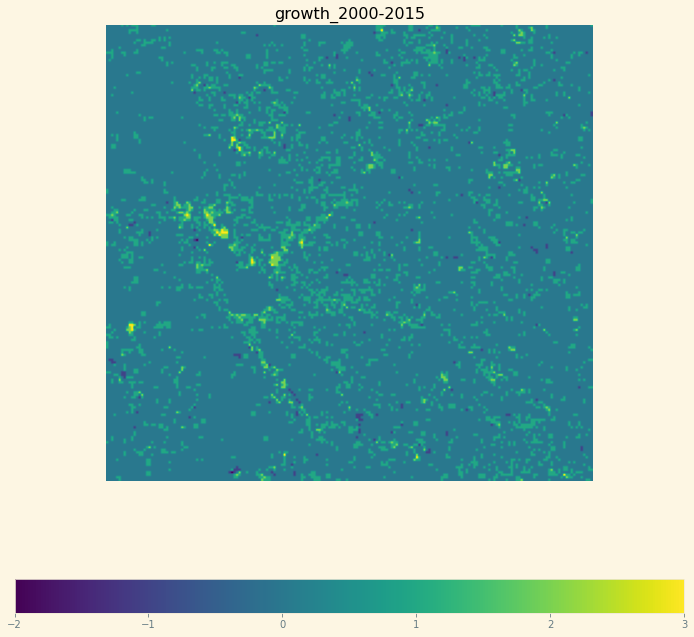

In [120]:
#show image and save
show_image(arr4-arr3,'growth_2000-2015',True)

# End

**FUNCTIONS FOR CALCULATING IMAGE STATS, BUT NOT USED IN THIS NOTEBOOK**

In [ ]:
def ndvi_stats(ndvi):
    
    # converting the value of image pixels into area
    areaImage = ndvi.multiply(ee.Image.pixelArea())
    
    # calculate the sum of ndvi values 
    ndvi_sum = areaImage.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: ndvi.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    #sparse vegetation 
    ndvi_sparse = areaImage.lt(0.4).And(areaImage.gt(0.2))
    #calculate stats
    ndvi_sparse = ndvi_sparse.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: ndvi.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    
    #med dense
    ndvi_med_dense=areaImage.lt(0.6).And(areaImage.gt(0.4))
    #calculate stats
    ndvi_med_dense = ndvi_med_dense.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: ndvi.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    
    # dense vegetation 
    ndvi_dense = areaImage.lt(1).And(areaImage.gt(0.6))
    #calculate stats
    ndvi_dense = ndvi_dense.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: ndvi.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    
    return ndvi_sum,ndvi_sparse,ndvi_med_dense,ndvi_dense

def buildup_stats(built_up_0):
    
    # converting the value of image pixels into area
    areaImage = built_up_0.multiply(ee.Image.pixelArea())
    
    # calculate the sum of builtup values 
    built_up_sum = built_up.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: built_up_0.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    #sparse 
    built_up_sparse = built_up.lt(0.4).And(built_up.gt(0.2))
    
    # cal stats 
    built_up_sparse=built_up_sparse.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: built_up_0.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
       
    #med 
    built_up_med_dense=built_up.lt(0.6).And(built_up.gt(0.4))
    
    # cal stats 
    built_up_med_dense=built_up_med_dense.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: built_up_0.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    
    
    # dense 
    built_up_dense = built_up.lt(1).And(built_up.gt(0.6))
    
    # cal stats 
    built_up_dense=built_up_dense.reduceRegion({
                  reducer: ee.Reducer.sum(),
                  geometry: built_up_0.geometry(),
                  scale: 30,
                  maxPixels: 1e9
                })
    
    
    return built_up_sum,built_up_sparse,built_up_med_dense,built_up_dense
def get_image_stats(image,parent_df=None,return_img=False):
    '''get  zonal statistics from given image, and append them to the parent dataframe,otherwise return the image with added ndvi,ndbi and bu bands'''
    
    # calc ndvi
    ndvi = image.normalizedDifference(['B4','B3'])
    
    # mask the non ndvi pixels
    mask_ndvi = ndvi.lt(0.2).And(ndvi.lt(0))
    
    # apply mask 
    ndvi = ndvi.updateMask(mask_ndvi).rename('NDVI')
    
    
    
    # calc ndbi
    ndbi = image.normalizedDifference(['B5','B4'])
    
    # mask the non ndvi pixels
    mask_ndbi = ndvi.lt(0.2).And(ndvi.lt(0))
    
    ndbi = ndbi.updateMask(mask_ndbi).rename('NDBI')
    
    # calc buildup 
    built_up = ndbi.subtract(ndvi).rename('BU')
    
    
    
    if return_img:
        image.addBands([ndvi,ndbi,built_up])
        
        return image
    
    
    
    return parent_df

# def cloud_mask(image):
    '''Remove cloudy pixels and remove pixels which donot exit in all the images for Landsat7 
    Source: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C01_T1_SR
    Input : Image (map onto the gee image collection
    ex: modified = Image_collection.map(cloud_mask)'''
#     qa = image.select('pixel_qa')
    
    # If the cloud bit (5) is set and the cloud confidence (7) is high
    # or the cloud shadow bit is set (3), then it's a bad pixel.
    
#     cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
#     #     Remove edge pixels that don't occur in all bands
#     mask2 = image.mask().reduce(ee.Reducer.min());
    
#     return image.updateMask(cloud.not()).updateMask(mask2)
    